---
title: "Football Player Data Analysis"
subtitle: "Part 3"
author:
  - name: "Oleksandr Solovei"
    affiliations:
        - 126784
        - https://github.com/s126784/fcd/
format:
  revealjs:
    slide-number: true
    show-slide-number: all
    chalkboard:
      buttons: false
    preview-links: auto
    logo: static/ua.png
    css: static/mystyle.css
    theme: default
    transition: slide
    # width: 1280
    # height: 720
jupyter: python3
---

## Project Evolution

#### Previous Parts

 - Part 1: Data Collection & Initial Analysis
 - Part 2: Text Analysis & Historical Data

::: {.fragment}
#### Part 3 Goals

 - Advanced text processing & sentiment analysis
 - Time series prediction for market values
 - Player clustering and network visualization
 - Market value trend prediction
:::

## Dataset

In [1]:
import pandas as pd

In [2]:
#| echo: true
years = [2014, 2015, 2016, 2017]
data = list(map(lambda year: pd.read_csv(f'data/portugal_{year}_plus.csv'), years))
data[0].head()

,#,Player,Age,Market value,Name,Position,search_results
0,7,Cristiano Ronaldo Centre-Forward,30.0,120000000,Cristiano Ronaldo,CF,8631215
1,6,William Carvalho Defensive Midfield,23.0,22000000,William Carvalho,DM,2809567
2,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1431291
3,5,Fábio Coentrão Left-Back,27.0,18000000,Fábio Coentrão,LB,503646
4,12,Rui Patrício Goalkeeper,27.0,18000000,Rui Patrício,GK,1485432


## Graphical Representation (Matplotlib)

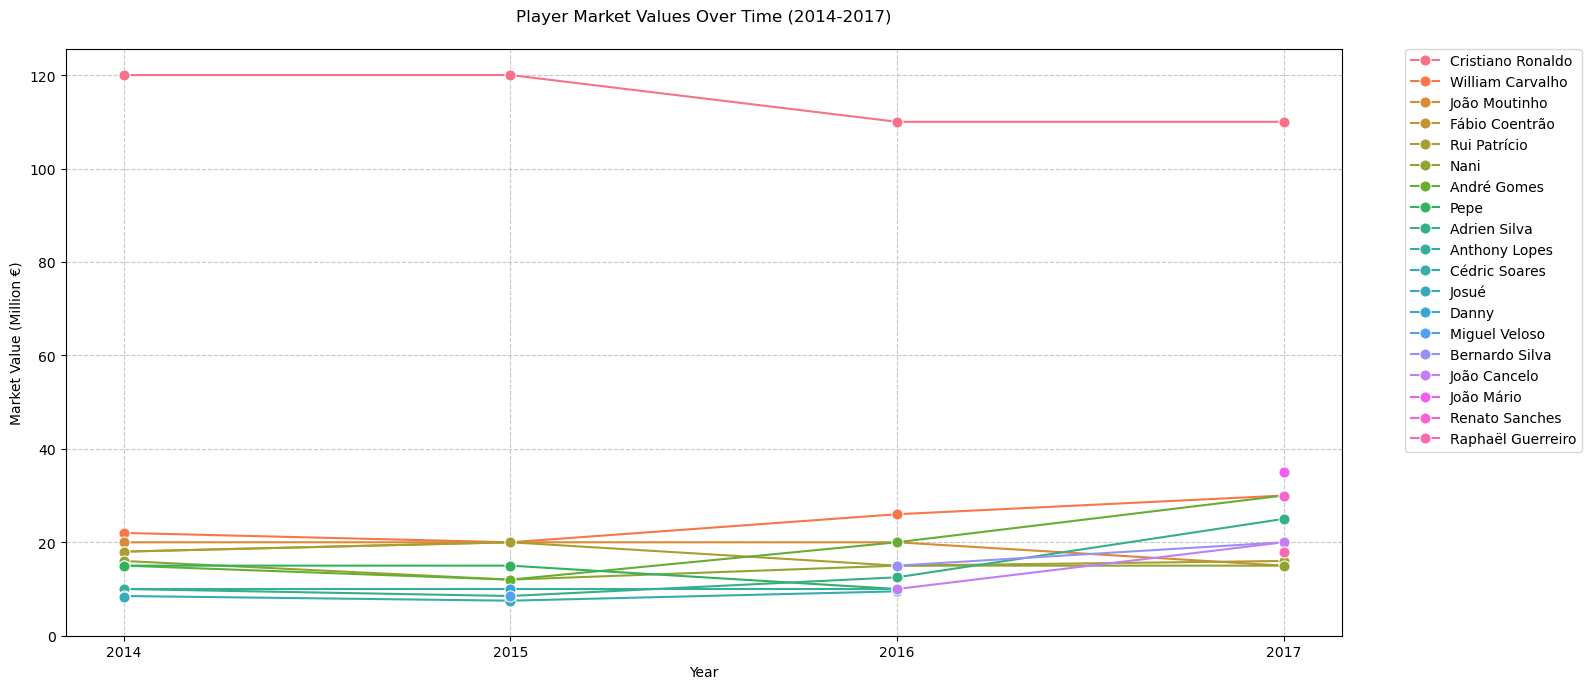

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_market_value_timeline(data_list, years):
    # Create a DataFrame for timeline plotting
    timeline_data = []

    for year, df in zip(years, data_list):
        year_data = df[['Name', 'Market value']].copy()
        year_data['Year'] = year
        year_data['Market value'] = year_data['Market value'].apply(lambda x: float(str(x).replace(',', '')))
        year_data['Market value'] = year_data['Market value'] / 1000000
        timeline_data.append(year_data)

    timeline_df = pd.concat(timeline_data)

    plt.figure(figsize=(16, 7))

    # Create the line plot
    sns.lineplot(data=timeline_df,
                x='Year',
                y='Market value',
                hue='Name',
                marker='o',
                markersize=8)

    # Set integer ticks on x-axis
    plt.xticks(years)

    plt.title('Player Market Values Over Time (2014-2017)', pad=20)
    plt.xlabel('Year')
    plt.ylabel('Market Value (Million €)')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(bottom=0)

    plt.tight_layout()
    return plt

# Create and display the timeline
plt = create_market_value_timeline(data, years)
plt.show()

## Graphical Representation (NetworkX)

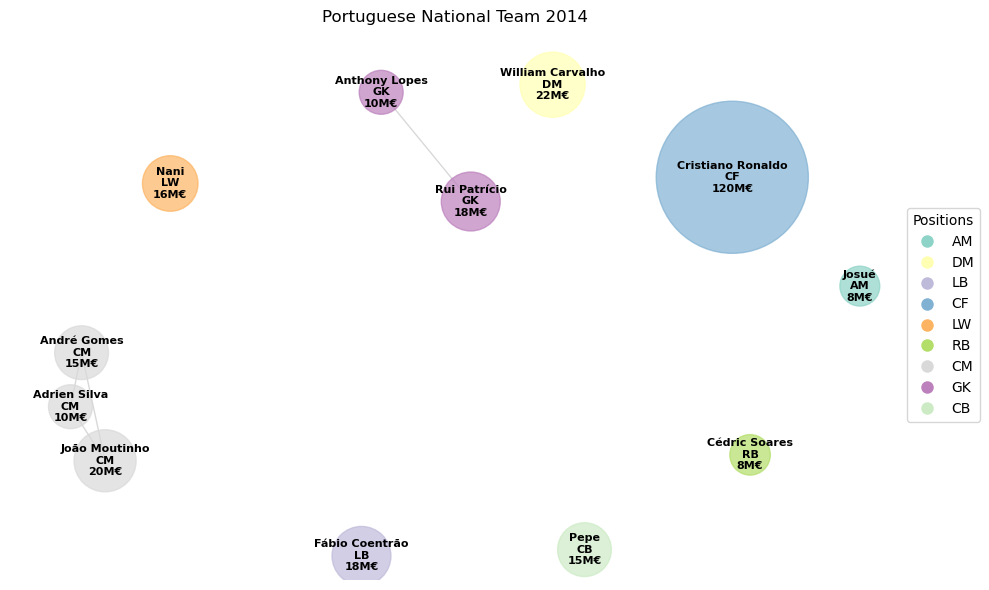

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def create_position_network(df):
    # Create a new graph
    G = nx.Graph()

    # Add nodes (players)
    for _, player in df.iterrows():
        # Convert market value to float, removing commas
        market_value = float(str(player['Market value']).replace(',', ''))
        G.add_node(player['Name'],
                  position=player['Position'],
                  market_value=market_value)

    # Connect players with same position
    players = list(G.nodes(data=True))
    for i in range(len(players)):
        for j in range(i + 1, len(players)):
            player1, data1 = players[i]
            player2, data2 = players[j]
            if data1['position'] == data2['position']:
                G.add_edge(player1, player2)

    # Create the visualization
    plt.figure(figsize=(10, 6))

    # Calculate node sizes based on market value (scaled for visibility)
    node_sizes = [G.nodes[player]['market_value']/1000000 * 100 for player in G.nodes()]

    # Create a color map based on positions
    unique_positions = list(set(nx.get_node_attributes(G, 'position').values()))
    color_map = {pos: plt.cm.Set3(i/len(unique_positions)) for i, pos in enumerate(unique_positions)}
    node_colors = [color_map[G.nodes[player]['position']] for player in G.nodes()]

    # Set up the layout
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Draw the network
    nx.draw_networkx_nodes(G, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          alpha=0.7)
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          alpha=0.3)

    # Add labels
    labels = {player: f"{player}\n{G.nodes[player]['position']}\n{int(G.nodes[player]['market_value']/1000000)}M€"
              for player in G.nodes()}

    nx.draw_networkx_labels(G, pos,
                           labels=labels,
                           font_size=8,
                           font_weight='bold')

    # Add legend for positions
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=color, label=pos,
                                 markersize=10)
                      for pos, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Positions',
              loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title('Portuguese National Team 2014', pad=20)
    plt.axis('off')
    plt.tight_layout()

    return plt

# Create and display the network using 2014 data
plt = create_position_network(data[0])
plt.show()

## Text Processing

In [5]:
#| echo: true
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

def advanced_tokenization(text):
    lemmatizer = WordNetLemmatizer()
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('portuguese'))
    # Remove non-alphabetic and stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens
             if t.isalpha() and t not in stop_words]
    return tokens

def get_sentiment_score(text):
    sentiment_analyzer = pipeline("sentiment-analysis",
                                model="neuralmind/bert-base-portuguese-cased")
    result = sentiment_analyzer(text)
    return result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score']

/opt/miniconda3/envs/ds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
text_data = pd.read_csv('data/url_content_extracted.csv')
text_data.head()

,url,html_content,extracted_text,status
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",Cristiano Ronaldo\nEsta página apresenta trech...,success
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",November 17 / 2024 How influential is Ronaldo ...,success
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",Manchester United vence a final a Carling Cup\...,success
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,Your browser does not support frames. Continue...,success
4,http://cristianoronaldoblog.blogs.sapo.pt/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",A transferência de Cristiano Ronaldo do Manche...,success


In [7]:
# Apply advanced tokenization
text_data['tokens'] = text_data['extracted_text'].apply(advanced_tokenization)
text_data

,url,html_content,extracted_text,status,tokens
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",Cristiano Ronaldo\nEsta página apresenta trech...,success,"[cristiano, ronaldo, página, apresenta, trecho..."
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",November 17 / 2024 How influential is Ronaldo ...,success,"[november, how, influential, is, ronaldo, to, ..."
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",Manchester United vence a final a Carling Cup\...,success,"[manchester, united, vence, final, carling, cu..."
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,Your browser does not support frames. Continue...,success,"[your, browser, doe, not, support, frame, cont..."
4,http://cristianoronaldoblog.blogs.sapo.pt/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",A transferência de Cristiano Ronaldo do Manche...,success,"[transferência, cristiano, ronaldo, manchester..."
...,...,...,...,...,...
277,http://rr.sapo.pt/bolabranca_detalhe.aspx?fid=...,\r\n<!--Nonio RR -->\r\n\r\n\r\n<!DOCTYPE html...,Em vésperas da estreia de Rúben Amorim como tr...,success,"[vésperas, estreia, rúben, amorim, treinador, ..."
278,http://expresso.sapo.pt/palavra/entity/people/...,<!DOCTYPE html> <!--[if lt IE 7]> <html c...,SAPO\nInício\nInício\nAtualidade\nDesporto\nEc...,success,"[sapo, início, início, atualidade, desporto, e..."
279,http://rr.sapo.pt/bolabranca_detalhe.aspx?fid=...,\r\n<!--Nonio RR -->\r\n\r\n\r\n<!DOCTYPE html...,Em vésperas da estreia de Rúben Amorim como tr...,success,"[vésperas, estreia, rúben, amorim, treinador, ..."
280,http://relvado.sapo.pt/sporting/cedric-soares-...,<!DOCTYPE html> <!--[if lt IE 7]> <html c...,SAPO\nInício\nInício\nAtualidade\nDesporto\nEc...,success,"[sapo, início, início, atualidade, desporto, e..."
